#1- Carga y Exploración Inicial de Datos:

In [ ]:
# Importacion de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Carga de datos
df = pd.read_csv("/content/insurance.csv")

In [ ]:
# Imprime todos los tipos de datos de las variables del df
print("Tipos de datos de las variables:")
display(df.dtypes)
# Imprime las primeras filas del df
print("Primeras filas del conjunto de datos:")
display(df.head())
# Imprime valores outliers
print(f"El conjunto de datos tiene {df.shape[0]} filas y {df.shape[1]} columnas.\n")
print("Resumen estadístico de las características numéricas:")
display(df.describe())

Tipos de datos de las variables:


,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


Primeras filas del conjunto de datos:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


El conjunto de datos tiene 1338 filas y 7 columnas.

Resumen estadístico de las características numéricas:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Selecciona solo columnas numericas
numeric_df = df.select_dtypes(include=np.number)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
# Definir límites de detección
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
# Ver cantidad de outliers por variable
outliers = ((numeric_df < limite_inferior) | (numeric_df > limite_superior)).sum()
print("Cantidad de outliers por variable:")
print(outliers)

Cantidad de outliers por variable:
age           0
bmi           9
children      0
charges     139
dtype: int64


In [ ]:
# Imprime todos los valores nulos por columna del df
print("Cantidad de valores nulos por columna:")
display(df.isnull().sum())
# Imprime la cantidad de valores únicos en cada columna del DataFrame.
print("Cantidad de valores únicos por columna:")
display(df.nunique())

Cantidad de valores nulos por columna:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


Cantidad de valores únicos por columna:


,0
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


Visualización de Distribuciones

<Figure size 1000x600 with 0 Axes>

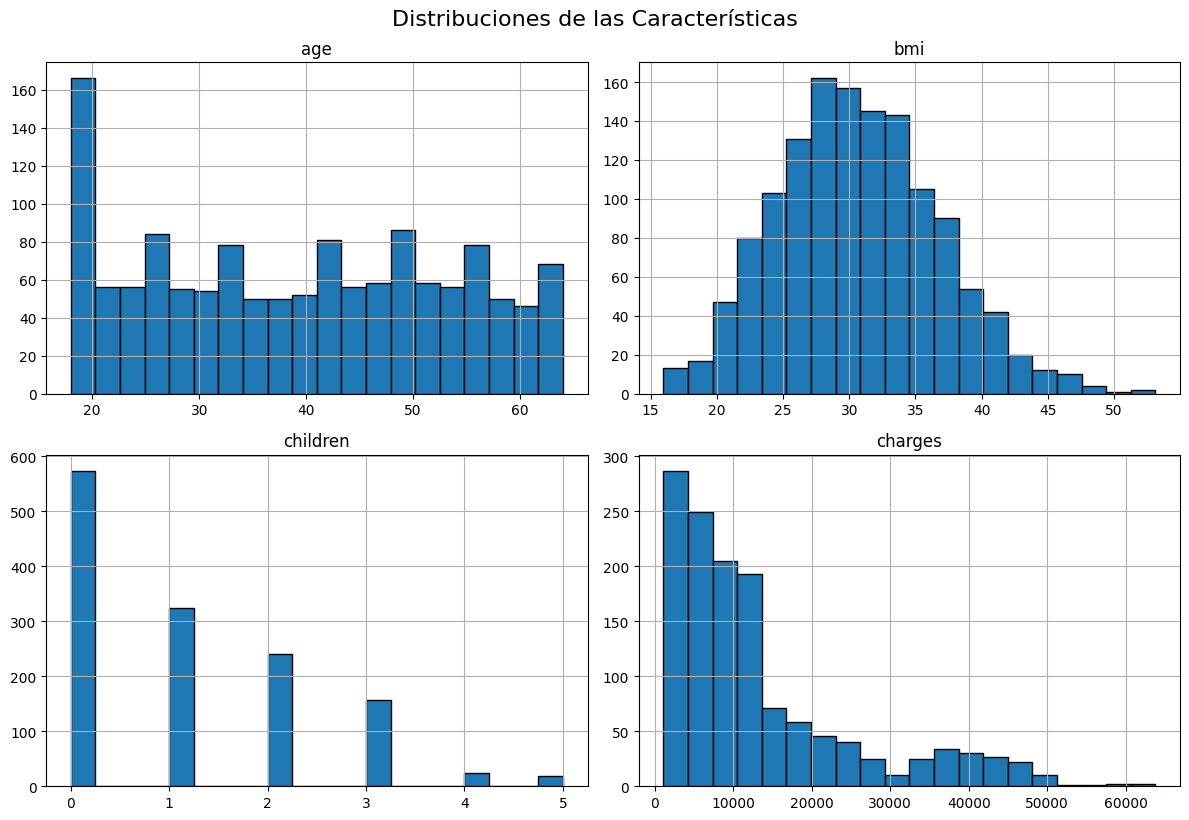

In [ ]:
# Visualizar las distribuciones de las características numéricas principales del conjunto de datos.
plt.figure(figsize=(10, 6))
# Generar histogramas para cada columna numérica del DataFrame:
df.hist(bins=20, figsize=(12, 8), edgecolor='black')
# Ajustar automáticamente los espacios entre subgráficos para evitar solapamientos.
plt.tight_layout()
# Agregar un título general a los histogramas.
plt.suptitle("Distribuciones de las Características", fontsize=16, y=1.02)
plt.show()

Mapa de calor

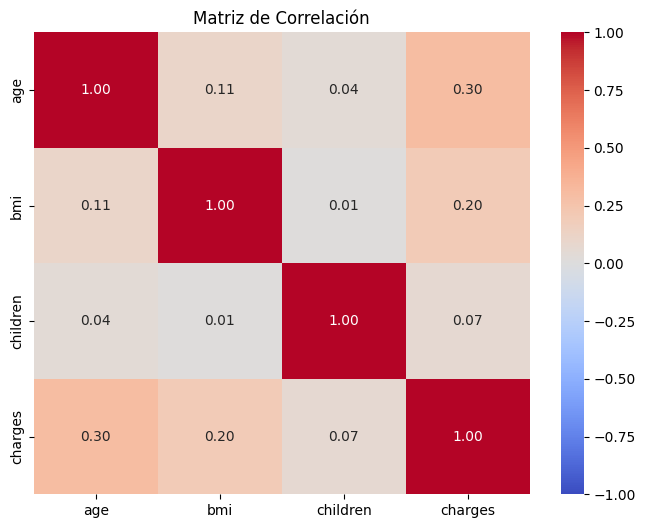

In [ ]:
# Calcular la matriz de correlación del df, para ver la relación lineal entre variables numéricas
# Excluir columnas no numéricas para evitar el error
correlation = df.select_dtypes(include=np.number).drop(columns=['Date'], errors='ignore').corr()  # Excluir columna 'Date' si existe
# Visualizar la matriz de correlación como un mapa de calor.
plt.figure(figsize=(8, 6))
# Generar el mapa de calor utilizando Seaborn:
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

#2- Preprocesamiento de Datos:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Definir columnas categóricas y numéricas
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'charges']
# Crear transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)
# Crear pipeline con el preprocesador
pipeline = Pipeline([
    ('preprocessing', preprocessor)  # Paso único: aplicar transformaciones
])
# Aplicar transformación
transformed_df = pipeline.fit_transform(df)
# Convertir a df con nombres de columnas
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
transformed_df = pd.DataFrame(transformed_df, columns=feature_names)

print(transformed_df)

      cat__sex_female  cat__sex_male  cat__smoker_no  cat__smoker_yes  \
0                 1.0            0.0             0.0              1.0   
1                 0.0            1.0             1.0              0.0   
2                 0.0            1.0             1.0              0.0   
3                 0.0            1.0             1.0              0.0   
4                 0.0            1.0             1.0              0.0   
...               ...            ...             ...              ...   
1333              0.0            1.0             1.0              0.0   
1334              1.0            0.0             1.0              0.0   
1335              1.0            0.0             1.0              0.0   
1336              1.0            0.0             1.0              0.0   
1337              1.0            0.0             0.0              1.0   

      cat__region_northeast  cat__region_northwest  cat__region_southeast  \
0                       0.0                   

#3- Implementación de Modelos de Clasificación:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Definir características y variable objetivo
X = df[['age', 'bmi', 'charges']]
y = df['children']  # Como variable de clasificación

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar los modelos
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression()
}

# Validación cruzada para cada modelo
print("Resultados de validación cruzada:")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name}: Precisión promedio = {np.mean(scores):.4f}")

# Optimización de hiperparámetros para KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train_scaled, y_train)
print(f"Mejor número de vecinos para KNN: {grid_search_knn.best_params_['n_neighbors']}")

# Optimización de hiperparámetros para Decision Tree
param_grid_dt = {'max_depth': [3, 5, 7, 10]}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_search_dt.fit(X_train_scaled, y_train)
print(f"Mejor profundidad del árbol de decisión: {grid_search_dt.best_params_['max_depth']}")

# Entrenar Regresión Logística con datos escalados
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
print("Modelo de Regresión Logística entrenado correctamente.")

Resultados de validación cruzada:
KNN: Precisión promedio = 0.4327
Decision Tree: Precisión promedio = 0.5065
Logistic Regression: Precisión promedio = 0.4252
Mejor número de vecinos para KNN: 5
Mejor profundidad del árbol de decisión: 10
Modelo de Regresión Logística entrenado correctamente.


#4- Optimización de Hiperparámetros:
Implementar GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Definir hiperparámetros para KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train_scaled, y_train)
print(f"Mejor número de vecinos para KNN: {grid_search_knn.best_params_['n_neighbors']}")

# Definir hiperparámetros para Árbol de Decisión
param_grid_dt = {'max_depth': [3, 5, 7, 10], 'criterion': ['gini', 'entropy']}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_search_dt.fit(X_train_scaled, y_train)
print(f"Mejor profundidad del Árbol de Decisión: {grid_search_dt.best_params_['max_depth']}")
print(f"Mejor criterio para el Árbol de Decisión: {grid_search_dt.best_params_['criterion']}")

# Definir hiperparámetros para Regresión Logística
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'saga']}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)
grid_search_lr.fit(X_train_scaled, y_train)
print(f"Mejor parámetro C para Regresión Logística: {grid_search_lr.best_params_['C']}")
print(f"Mejor solver para Regresión Logística: {grid_search_lr.best_params_['solver']}")



Mejor número de vecinos para KNN: 5
Mejor profundidad del Árbol de Decisión: 10
Mejor criterio para el Árbol de Decisión: gini
Mejor parámetro C para Regresión Logística: 0.01
Mejor solver para Regresión Logística: lbfgs


Implementar RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# Definir hiperparámetros para KNN
param_dist_knn = {'n_neighbors': np.arange(1, 15)}
random_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, scoring='accuracy', cv=5, n_iter=10, n_jobs=-1, random_state=42)
random_search_knn.fit(X_train_scaled, y_train)
print(f"Mejor número de vecinos para KNN: {random_search_knn.best_params_['n_neighbors']}")

# Definir hiperparámetros para Árbol de Decisión
param_dist_dt = {'max_depth': np.arange(3, 15), 'criterion': ['gini', 'entropy']}
random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist_dt, scoring='accuracy', cv=5, n_iter=10, n_jobs=-1, random_state=42)
random_search_dt.fit(X_train_scaled, y_train)
print(f"Mejor profundidad del Árbol de Decisión: {random_search_dt.best_params_['max_depth']}")
print(f"Mejor criterio para el Árbol de Decisión: {random_search_dt.best_params_['criterion']}")

# Definir hiperparámetros para Regresión Logística
param_dist_lr = {'C': np.logspace(-3, 2, 10), 'solver': ['lbfgs', 'saga']}
random_search_lr = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist_lr, scoring='accuracy', cv=5, n_iter=10, n_jobs=-1, random_state=42)
random_search_lr.fit(X_train_scaled, y_train)
print(f"Mejor parámetro C para Regresión Logística: {random_search_lr.best_params_['C']}")
print(f"Mejor solver para Regresión Logística: {random_search_lr.best_params_['solver']}")


Mejor número de vecinos para KNN: 2
Mejor profundidad del Árbol de Decisión: 12
Mejor criterio para el Árbol de Decisión: entropy
Mejor parámetro C para Regresión Logística: 0.001
Mejor solver para Regresión Logística: lbfgs


#5- Evaluación de Modelos:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluar el mejor modelo de cada técnica
models = {
    "KNN": grid_search_knn.best_estimator_,
    "Decision Tree": grid_search_dt.best_estimator_,
    "Logistic Regression": grid_search_lr.best_estimator_
}

print("Evaluación de modelos optimizados:")
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)  # Línea actualizada
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Para ROC-AUC, verificar si la variable objetivo tiene más de dos clases
    if len(set(y_test)) == 2:  # Clasificación binaria
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])
        print(f"{name}: Exactitud = {accuracy:.4f}, Precisión = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}")
    else:  # Multiclase (sin ROC-AUC)
        print(f"{name}: Exactitud = {accuracy:.4f}, Precisión = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}")


Evaluación de modelos optimizados:
KNN: Exactitud = 0.4366, Precisión = 0.3835, Recall = 0.4366, F1-Score = 0.3897
Decision Tree: Exactitud = 0.4590, Precisión = 0.4501, Recall = 0.4590, F1-Score = 0.4476
Logistic Regression: Exactitud = 0.4403, Precisión = 0.7536, Recall = 0.4403, F1-Score = 0.2692


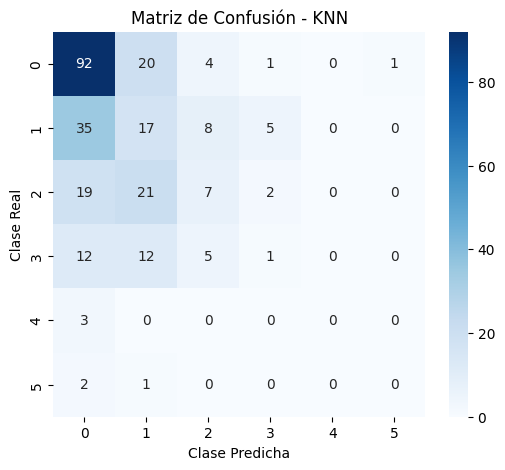

Análisis de la Matriz de Confusión para KNN:
[[92 20  4  1  0  1]
 [35 17  8  5  0  0]
 [19 21  7  2  0  0]
 [12 12  5  1  0  0]
 [ 3  0  0  0  0  0]
 [ 2  1  0  0  0  0]]


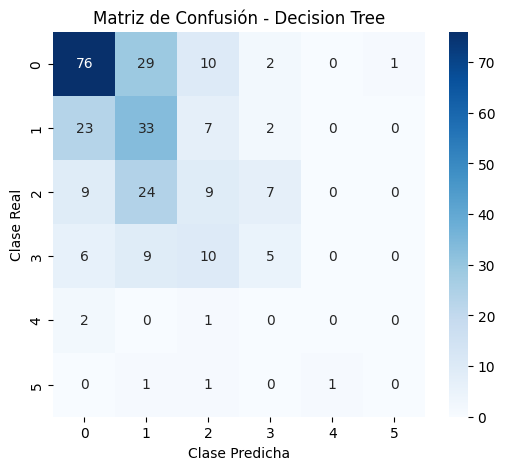

Análisis de la Matriz de Confusión para Decision Tree:
[[76 29 10  2  0  1]
 [23 33  7  2  0  0]
 [ 9 24  9  7  0  0]
 [ 6  9 10  5  0  0]
 [ 2  0  1  0  0  0]
 [ 0  1  1  0  1  0]]


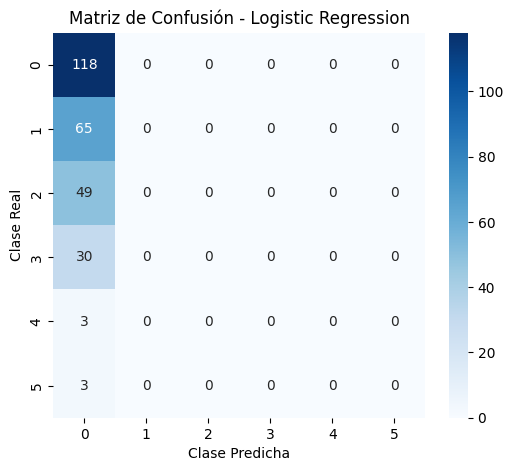

Análisis de la Matriz de Confusión para Logistic Regression:
[[118   0   0   0   0   0]
 [ 65   0   0   0   0   0]
 [ 49   0   0   0   0   0]
 [ 30   0   0   0   0   0]
 [  3   0   0   0   0   0]
 [  3   0   0   0   0   0]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluar los mejores modelos
models = {
    "KNN": grid_search_knn.best_estimator_,
    "Decision Tree": grid_search_dt.best_estimator_,
    "Logistic Regression": grid_search_lr.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # Generar matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Clase Predicha')
    plt.ylabel('Clase Real')
    plt.show()

    # Analizar matriz de confusión
    print(f"Análisis de la Matriz de Confusión para {name}:")
    print(conf_matrix)


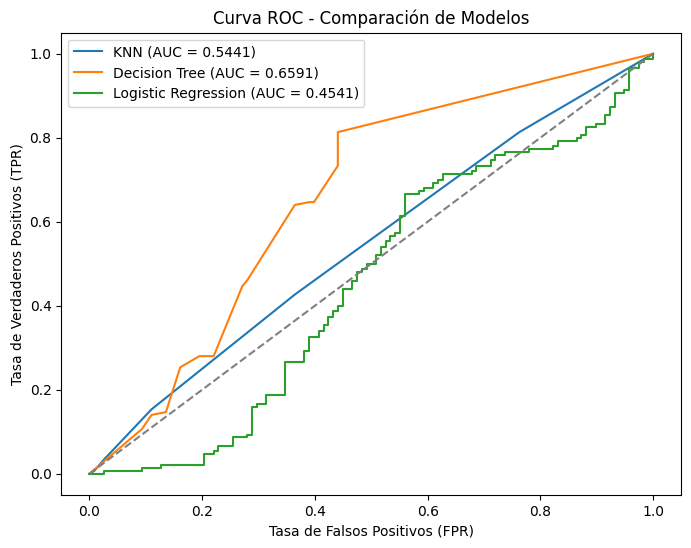

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Convertir la variable objetivo a binaria, ya que daba un error de multiclase
df['children_binary'] = df['children'].apply(lambda x: 1 if x > 0 else 0)
y = df['children_binary']  # Asegurar que 'y' sea la versión binaria

# Dividir los datos en entrenamiento y prueba con la variable actualizada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Asegurar que 'y_test' sea tipo entero
y_test = y_test.astype(int)

# Definir los modelos optimizados
models = {
    "KNN": grid_search_knn.best_estimator_,
    "Decision Tree": grid_search_dt.best_estimator_,
    "Logistic Regression": grid_search_lr.best_estimator_
}

# Generar y visualizar la curva ROC
plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Calcular probabilidades de la clase positiva
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Generar la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

# Agregar línea diagonal de referencia
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Configurar el gráfico
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Comparación de Modelos")
plt.legend()
plt.show()